In [9]:
import pandas as pd
import os 
import base64
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPooling2D,Flatten,Dropout,Rescaling
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam,RMSprop

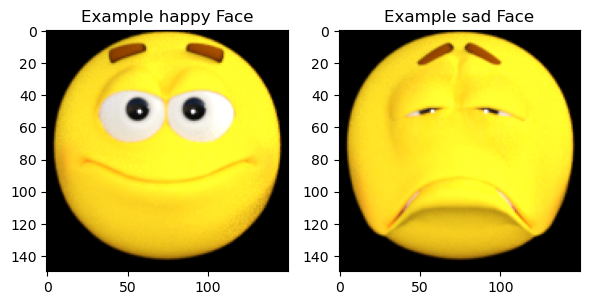

In [3]:
BASE_DIR = "./data/"
happy_dir = os.path.join(BASE_DIR, "happy/")
sad_dir = os.path.join(BASE_DIR, "sad/")

fig, axs = plt.subplots(1, 2, figsize=(6, 6))
axs[0].imshow(tf.keras.utils.load_img(f"{os.path.join(happy_dir, os.listdir(happy_dir)[0])}"))
axs[0].set_title('Example happy Face')

axs[1].imshow(tf.keras.utils.load_img(f"{os.path.join(sad_dir, os.listdir(sad_dir)[0])}"))
axs[1].set_title('Example sad Face')

plt.tight_layout()

In [4]:
sample_image  = tf.keras.utils.load_img(f"{os.path.join(happy_dir, os.listdir(happy_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = tf.keras.utils.img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

print(f"The maximum pixel value used is: {np.max(sample_array)}")

Each image has shape: (150, 150, 3)
The maximum pixel value used is: 255.0


In [5]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        if(logs['accuracy']>=0.999):
            self.model.stop_training=True
            print("\nReached 99.9% accuracy so cancelling training!")

In [12]:
def training_dataset():
    train_dataset=tf.keras.utils.image_dataset_from_directory(
        directory=BASE_DIR,
        image_size=(150,150),
        batch_size=10,
        label_mode='binary'
    )

    rescale_layer=Rescaling(scale=(1./255))

    train_dataset_scaled=train_dataset.map(lambda image,label:(rescale_layer(image),label))
    return train_dataset_scaled

In [13]:
train_data = training_dataset()

for images, labels in train_data.take(1):
    print(f"Range for pixel values: {np.min(images[0]), np.max(images[0])}")

print(f"train_data is an instance of tf.data.Dataset: {isinstance(train_data, tf.data.Dataset)}")

Found 80 files belonging to 2 classes.
Range for pixel values: (0.0, 1.0)
train_data is an instance of tf.data.Dataset: True


2025-07-19 11:15:53.319005: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
def create_and_compile_model():
    model=Sequential([
        Input(shape=(150,150,3)),
        Conv2D(16,(3,3),activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(32,(3,3),activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(64,(3,3),activation='relu'),
        Flatten(),
        Dense(512,activation='relu'),
        Dense(1,activation='sigmoid')
    ])

    model.summary()

    model.compile(loss='binary_crossentropy',optimizer='RMSProp',metrics=['accuracy'])
    
    return model

In [15]:
model=create_and_compile_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73984)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    37,880,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,904,417 (144.59 MB)

 Trainable params: 37,904,417 (144.59 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
training_history=model.fit(x=train_data,epochs=15)

Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 497ms/step - accuracy: 1.0000 - loss: 0.0033
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 506ms/step - accuracy: 1.0000 - loss: 0.0051
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 492ms/step - accuracy: 1.0000 - loss: 0.0032
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 508ms/step - accuracy: 1.0000 - loss: 0.0015
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 502ms/step - accuracy: 1.0000 - loss: 8.9891e-04
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 505ms/step - accuracy: 1.0000 - loss: 5.3979e-04
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 488ms/step - accuracy: 1.0000 - loss: 4.5921e-04
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 491ms/step - accuracy: 1.0000 - loss: 3.5790e-04
Epoch 9/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 486ms/step - accuracy: 1.0000 - loss: 2.1550e-04
Epoch 10/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 509ms/step - accuracy: 1.0000 - loss: 1.2618e-04
Epoch 11/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 542ms/step - accuracy: 1.0000 - loss: 1.0975e-04
Epoch 12/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 537ms/

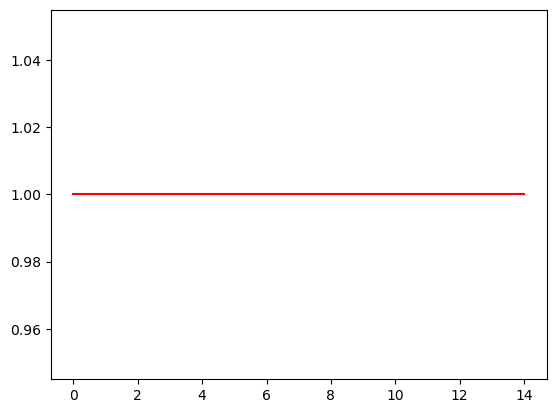

In [18]:
acc=training_history.history['accuracy']
epochs=range(len(acc))
plt.plot(epochs,acc,'r',label='Training_accuracy')
